In [1]:
abstract type AbstractLayer end

In [2]:
mutable struct MulLayer{T<:AbstractFloat} <: AbstractLayer
    x::T
    y::T
    (::Type{MulLayer{T}})() where {T<:AbstractFloat} = new{T}()
end

In [3]:
function forward(self::MulLayer{T}, x::T, y::T) where {T<:AbstractFloat}
    self.x = x
    self.y = y
    out = x * y
    return out
end
@inline forward(lyr::MulLayer{T}, x, y) where T = forward(lyr, T(x), T(y))

forward (generic function with 2 methods)

In [4]:
function backward(self::MulLayer{T}, dout::T) where {T<:AbstractFloat}
    dx = dout * self.y
    dy = dout * self.x
    return dx, dy
end
@inline backward(lyr::MulLayer{T}, dout) where T = backward(lyr, T(dout))

backward (generic function with 2 methods)

In [5]:
apple = 100
apple_num = 2
tax = 1.1

1.1

In [6]:
mul_apple_layer = MulLayer{Float32}()
mul_tax_layer = MulLayer{Float32}()

MulLayer{Float32}(7.0f-45, 0.0f0)

In [7]:
apple_price = forward(mul_apple_layer, apple, apple_num)
price = forward(mul_tax_layer, apple_price, tax)

220.0f0

In [8]:
dprice = 1
dapple_price, dtax = backward(mul_tax_layer, dprice)
dapple, dapple_num = backward(mul_apple_layer, dapple_price)
(dapple, dapple_num, dtax)

(2.2f0, 110.0f0, 200.0f0)

In [9]:
mutable struct AddLayer{T<:AbstractFloat} <: AbstractLayer end

function forward(self::AddLayer{T}, x::T, y::T) where {T<:AbstractFloat}
    out = x + y
    return out
end
@inline forward(lyr::AddLayer{T}, x, y) where T = forward(lyr, T(x), T(y))
    
function backward(self::AddLayer{T}, dout::T) where {T<:AbstractFloat}
    dx = dout * 1
    dy = dout * 1
    return dx, dy
end
@inline backward(lyr::AddLayer{T}, dout) where T = backward(lyr, T(dout))

backward (generic function with 4 methods)

In [10]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

1.1

In [11]:
mul_apple_layer = MulLayer{Float32}()
mul_orange_layer = MulLayer{Float32}()
add_apple_orange_layer = AddLayer{Float32}()
mul_tax_layer = MulLayer{Float32}()

MulLayer{Float32}(1.160496f20, 4.5761f-41)

In [12]:
apple_price = forward(mul_apple_layer, apple, apple_num)
orange_price = forward(mul_orange_layer, orange, orange_num)
all_price = forward(add_apple_orange_layer, apple_price, orange_price)
price = forward(mul_tax_layer, all_price, tax)

715.0f0

In [13]:
dprice = 1
dall_price, dtax = backward(mul_tax_layer, dprice)
dapple_price, dorange_price = backward(add_apple_orange_layer, dall_price)
dorange, dorange_num = backward(mul_orange_layer, dorange_price)
dapple, dapple_num = backward(mul_apple_layer, dapple_price)
(dapple, dapple_num, dorange, dorange_num, dtax)

(2.2f0, 110.0f0, 3.3000002f0, 165.0f0, 650.0f0)

## Relu

In [14]:
mutable struct ReluLayer{T<:AbstractFloat} <: AbstractLayer
    mask::AbstractArray{Bool}
    (::Type{ReluLayer{T}})() where {T} = new{T}()
end

In [15]:
function forward(self::ReluLayer{T}, x::AbstractArray{T}) where {T<:AbstractFloat}
    mask = self.mask = (x .<= 0)
    out = copy(x)
    out[mask] .= zero(T)
    out
end

forward (generic function with 5 methods)

In [16]:
function backward(self::ReluLayer{T}, dout::AbstractArray{T}) where {T<:AbstractFloat}
    dout[self.mask] .= zero(T)
    dout
end

backward (generic function with 5 methods)

In [17]:
relulyr = ReluLayer{Float32}()
forward(relulyr, Float32[1.0 -0.5; -2.0 3.0])

2×2 Array{Float32,2}:
 1.0  0.0
 0.0  3.0

In [18]:
relulyr.mask

2×2 Array{Bool,2}:
 false   true
  true  false

In [19]:
backward(relulyr, Float32[1.0 1.0; 1.0 1.0])

2×2 Array{Float32,2}:
 1.0  0.0
 0.0  1.0

## Sigmoid

In [20]:
mutable struct SigmoidLayer{T<:AbstractFloat} <: AbstractLayer
    out::AbstractArray{T}
    (::Type{SigmoidLayer{T}})() where {T} = new{T}()
end

In [21]:
function forward(self::SigmoidLayer{T}, x::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    self.out = one(T) ./ (one(T) .+ exp.(.-x))
end

forward (generic function with 6 methods)

In [22]:
function backward(self::SigmoidLayer{T}, dout::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    dout .* (one(T) .- self.out) .* self.out
end

backward (generic function with 6 methods)

In [23]:
sigmoidlyr = SigmoidLayer{Float32}()
forward(sigmoidlyr, Float32[-5:5;])

11-element Array{Float32,1}:
 0.00669285
 0.0179862 
 0.0474259 
 0.119203  
 0.268941  
 0.5       
 0.731059  
 0.880797  
 0.952574  
 0.982014  
 0.993307  

In [24]:
backward(sigmoidlyr, ones(Float32,11))

11-element Array{Float32,1}:
 0.00664806
 0.0176627 
 0.0451767 
 0.104994  
 0.196612  
 0.25      
 0.196612  
 0.104994  
 0.0451767 
 0.0176627 
 0.00664803

### 5.6.2 バッチ版 Affine レイヤ

In [25]:
mutable struct AffineLayer{T<:AbstractFloat} <: AbstractLayer
    W::AbstractMatrix{T}
    b::AbstractVector{T}
    x::AbstractArray{T}
    dW::AbstractMatrix{T}
    db::AbstractVector{T}
    function (::Type{AffineLayer})(W::AbstractMatrix{T}, b::AbstractVector{T}) where {T}
        lyr = new{T}()
        lyr.W = W
        lyr.b = b
        lyr
    end
end

In [26]:
function forward(self::AffineLayer{T}, x::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    self.x = x
    self.W * x .+ self.b
end

forward (generic function with 7 methods)

In [27]:
function backward(self::AffineLayer{T}, dout::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    dx = self.W' * dout
    self.dW = dout * self.x'
    self.db = _sumvec(dout)
    dx
end
@inline _sumvec{T}(dout::AbstractVector{T}) = dout
@inline _sumvec{T}(dout::AbstractMatrix{T}) = vec(mapslices(sum, dout, 2))
@inline _sumvec{T,N}(dout::AbstractArray{T,N}) = vec(mapslices(sum, dout, 2:N))

_sumvec (generic function with 3 methods)

### 5.6.3 Softmax-with-Loss レイヤ

In [28]:
function softmax(a::AbstractVector{T}) where {T<:AbstractFloat}
    c = maximum(a)  # オーバーフロー対策
    exp_a = exp.(a .- c)
    exp_a ./ sum(exp_a)
end

function softmax(a::AbstractMatrix{T}) where {T<:AbstractFloat}
    mapslices(softmax, a, 1)
end

softmax (generic function with 2 methods)

In [29]:
function crossentropyerror(y::Vector, t::Vector)
    δ = 1e-7  # アンダーフロー対策
    # -sum(t .* log.(y .+ δ))
    -(t ⋅ log.(y .+ δ))
end
function crossentropyerror(y::Matrix, t::Matrix)
    batch_size = size(y, 2)
    δ = 1e-7  # アンダーフロー対策
    # -sum(t .* log(y .+ δ)) / batch_size
    -vecdot(t, log.(y .+ δ)) / batch_size
end
function crossentropyerror(y::Matrix, t::Vector)
    batch_size = size(y, 2)
    δ = 1e-7  # アンダーフロー対策
    -sum([log.(y[t[i]+1, i]) for i=1:batch_size] .+ δ) / batch_size
end

crossentropyerror (generic function with 3 methods)

In [30]:
mutable struct SoftmaxWithLossLayer{T<:AbstractFloat} <: AbstractLayer
    loss::T
    y::AbstractArray{T}
    t::AbstractArray{T}
    (::Type{SoftmaxWithLossLayer{T}})() where {T} = new{T}()
end

In [31]:
function forward(self::SoftmaxWithLossLayer{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    self.t = t
    y = self.y = softmax(x)
    self.loss = crossentropyerror(y, t)
end

forward (generic function with 8 methods)

In [32]:
function backward(lyr::SoftmaxWithLossLayer{T}, dout::T=one(T)) where {T<:AbstractFloat}
    dout .* _swlvec(lyr.y, lyr.t)
end
@inline _swlvec(y::AbstractArray{T}, t::AbstractVector{T}) where {T<:AbstractFloat} = y .- t
@inline _swlvec(y::AbstractArray{T}, t::AbstractMatrix{T}) where {T<:AbstractFloat} = (y .- t) / size(t)[2]

_swlvec (generic function with 2 methods)

### 5.7.2 誤差逆伝播法に対応したニューラルネットワークの実装

In [33]:
mutable struct TwoLayerNet{T<:AbstractFloat}
    a1lyr::AffineLayer{T}
    relu1lyr::ReluLayer
    a2lyr::AffineLayer{T}
    softmaxlyr::SoftmaxWithLossLayer{T}
end

function (::Type{TwoLayerNet{T}})(input_size::Int, hidden_size::Int, output_size::Int,
        weight_init_std::T=T(0.01)) where {T<:AbstractFloat}
    W1 = weight_init_std .* randn(T, hidden_size, input_size)
    b1 = zeros(T, hidden_size)
    W2 = weight_init_std .* randn(T, output_size, hidden_size)
    b2 = zeros(T, output_size)
    a1lyr = AffineLayer(W1, b1)
    relu1lyr = ReluLayer{T}()
    a2lyr = AffineLayer(W2, b2)
    softmaxlyr = SoftmaxWithLossLayer{T}()
    TwoLayerNet(a1lyr, relu1lyr, a2lyr, softmaxlyr)
end

In [34]:
function predict(net::TwoLayerNet{T}, x::AbstractArray{T}) where {T<:AbstractFloat}
    a1 = forward(net.a1lyr, x)
    z1 = forward(net.relu1lyr, a1)
    a2 = forward(net.a2lyr, z1)
    # softmax(a2)
    a2
end

predict (generic function with 1 method)

In [35]:
function loss(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    y = predict(net, x)
    forward(net.softmaxlyr, y, t)
end

loss (generic function with 1 method)

In [36]:
function accuracy(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    y = vec(mapslices(indmax, predict(net, x), 1))
    if ndims(t) > 1 t = vec(mapslices(indmax, t, 1)) end
    mean(y .== t)
end

accuracy (generic function with 1 method)

In [37]:
struct TwoLayerNetGrads{T}
    W1::AbstractMatrix{T}
    b1::AbstractVector{T}
    W2::AbstractMatrix{T}
    b2::AbstractVector{T}
end

In [38]:
function Base.gradient(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    # forward
    loss(net, x, t)
    # backward
    dout = one(T)
    dz2 = backward(net.softmaxlyr, dout)
    da2 = backward(net.a2lyr, dz2)
    dz1 = backward(net.relu1lyr, da2)
    da1 = backward(net.a1lyr, dz1)
    TwoLayerNetGrads(net.a1lyr.dW, net.a1lyr.db, net.a2lyr.dW, net.a2lyr.db)
end

In [39]:
function applygradient!(net::TwoLayerNet{T}, grads::TwoLayerNetGrads{T}, learning_rate::T) where {T<:AbstractFloat}
    net.a1lyr.W -= learning_rate .* grads.W1
    net.a1lyr.b -= learning_rate .* grads.b1
    net.a2lyr.W -= learning_rate .* grads.W2
    net.a2lyr.b -= learning_rate .* grads.b2
end

applygradient! (generic function with 1 method)

### 5.7.3 誤差逆伝播法の勾配確認

In [40]:
include("dataset/load_mnist.jl")

LoadMnist

In [41]:
(x_train, t_train), (x_test, t_test) = LoadMnist.load_mnist(;
        normalize=true, flatten=true, one_hot_label=true)

((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x00 0x01 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x01; 0x00 0x00 … 0x00 0x00]), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00]))

In [42]:
size(t_train)

(10, 60000)

In [43]:
network = TwoLayerNet{Float32}(784, 50, 10)

TwoLayerNet{Float32}(AffineLayer{Float32}(Float32[0.00318988 0.00485958 … 0.00432392 -0.00266472; 0.00109636 0.00661024 … 0.0103529 0.00247615; … ; -0.000739207 0.0207509 … -6.73199f-5 0.0100186; 0.011015 0.0093262 … 0.00189109 -0.0164121], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), ReluLayer{Float32}(#undef), AffineLayer{Float32}(Float32[0.00970453 -0.00344387 … -0.00698218 0.00117947; 0.00413081 0.000712915 … -0.00246677 -0.00750007; … ; 0.00190007 -0.00820374 … 0.00863559 -0.0117912; -0.0139849 0.00173204 … -0.000736556 0.00177398], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), SoftmaxWithLossLayer{Float32}(7.6892265f20, #undef, #undef))

In [44]:
x_batch = x_train[:, 1:3]

784×3 Array{Float32,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [45]:
t_batch = Matrix{Float32}(t_train[:, 1:3])

10×3 Array{Float32,2}:
 0.0  1.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [46]:
predict(network, x_batch)

10×3 Array{Float32,2}:
 -0.0011316    -0.0014604   -0.000707305
 -0.00289681    0.0045625    0.00177277 
 -0.000804678  -0.00404845   0.00219935 
  0.00101501    0.00697281   0.000847883
 -0.00777562   -0.00674609  -0.00108261 
 -0.00570799   -0.0101445   -0.000680426
 -0.00433399   -0.00503931  -0.000889094
  0.00661214    0.00467918   0.00023113 
 -0.00730404   -0.00778527   0.000421932
  0.00122218   -0.00650803  -0.00211031 

In [47]:
loss(network, x_batch, t_batch)
# loss(network, x_batch, Matrix{Float32}(t_batch))

2.303789029815617

In [48]:
grad_backprop = gradient(network, x_batch, t_batch)

TwoLayerNetGrads{Float32}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[-0.00222329, 0.00170545, -0.00132295, 0.0, -0.00491989, 0.0, 0.00502056, 0.0, 0.00248478, 0.00177194  …  -0.00875813, 0.00109634, 0.00871906, -0.00546616, 0.000614705, -0.000547221, 0.00571311, 0.00147637, -0.00292858, 0.0], Float32[0.00182903 -0.0109375 … -0.0491178 0.0; 0.00183358 0.00400405 … 0.0101247 0.0; … ; 0.0018311 0.0039746 … 0.0100359 0.0; 0.00182647 0.00399781 … 0.0100695 0.0], Float32[-0.233289, 0.10027, 0.100066, 0.100451, -0.233698, -0.233729, 0.0998127, 0.100541, 0.0996665, 0.0999085])

### 5.7.4 誤差逆伝播法を使った学習

In [49]:
network = TwoLayerNet{Float32}(784, 50, 10)

TwoLayerNet{Float32}(AffineLayer{Float32}(Float32[-0.0145858 0.0112641 … -0.00181048 -0.00982263; -0.00418988 0.000436219 … 0.0169963 -0.00666518; … ; -0.00234774 -0.0183891 … -0.0095593 -0.00152059; -0.0075102 0.00935047 … 0.000530805 -0.0067455], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), ReluLayer{Float32}(#undef), AffineLayer{Float32}(Float32[-0.00512687 -0.0145102 … -0.00207356 0.0202991; -0.00433898 0.0068244 … 0.00575347 -0.0205735; … ; -0.0189138 0.0150627 … -0.0172908 0.000555763; 0.00474322 -0.0054643 … -0.00044954 -0.0116008], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), SoftmaxWithLossLayer{Float32}(7.6892265f20, #undef, #undef))

In [50]:
iters_num = 10000;
train_size = size(x_train, 2); # => 60000
batch_size = 100;
learning_rate = Float32(0.1);

In [51]:
train_loss_list = Float32[];
train_acc_list = Float32[];
test_acc_list = Float32[];

In [52]:
iter_per_epoch = max(train_size ÷ batch_size, 1)

600

In [53]:
for i = 1:iters_num
    batch_mask = rand(1:train_size, batch_size)
    x_batch = x_train[:, batch_mask]
    t_batch = Matrix{Float32}(t_train[:, batch_mask])
    
    # 誤差逆伝播法によって勾配を求める
    grads = gradient(network, x_batch, t_batch)
    
    # 更新
    applygradient!(network, grads, learning_rate)
    
    _loss = loss(network, x_batch, t_batch)
    push!(train_loss_list, _loss)

    if i % iter_per_epoch == 1
        train_acc = accuracy(network, x_train, Matrix{Float32}(t_train))
        test_acc = accuracy(network, x_test, Matrix{Float32}(t_test))
        push!(train_acc_list, train_acc)
        push!(test_acc_list, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.15588333333333335 / test_acc=0.1581
600: train_acc=0.9048833333333334 / test_acc=0.9073
1200: train_acc=0.92345 / test_acc=0.925
1800: train_acc=0.9356833333333333 / test_acc=0.9366
2400: train_acc=0.9428166666666666 / test_acc=0.9426
3000: train_acc=0.951 / test_acc=0.9468
3600: train_acc=0.9546666666666667 / test_acc=0.9517
4200: train_acc=0.9602 / test_acc=0.9552
4800: train_acc=0.9620666666666666 / test_acc=0.9577
5400: train_acc=0.96585 / test_acc=0.9614
6000: train_acc=0.9685833333333334 / test_acc=0.9629
6600: train_acc=0.9716166666666667 / test_acc=0.9634
7200: train_acc=0.9726833333333333 / test_acc=0.9635
7800: train_acc=0.9729 / test_acc=0.965
8400: train_acc=0.9748666666666667 / test_acc=0.9662
9000: train_acc=0.9767666666666667 / test_acc=0.9692
9600: train_acc=0.9782333333333333 / test_acc=0.9665


In [54]:
final_train_acc = accuracy(network, x_train, Matrix{Float32}(t_train))
final_test_acc = accuracy(network, x_test, Matrix{Float32}(t_test))
push!(train_acc_list, final_train_acc)
push!(test_acc_list, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.9794666666666667 / test_acc=0.9689


In [55]:
using PyPlot
const plt = PyPlot

PyPlot

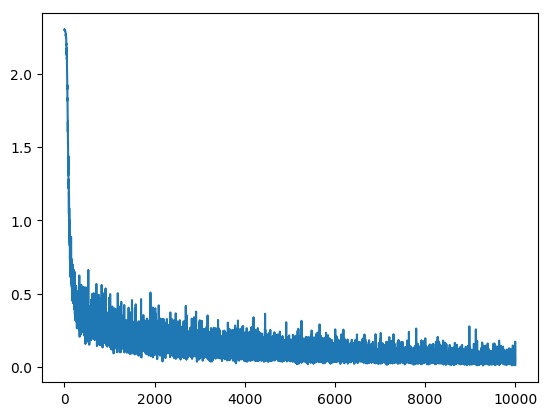

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f903b33af98>

In [56]:
plt.plot(1:length(train_loss_list), train_loss_list)

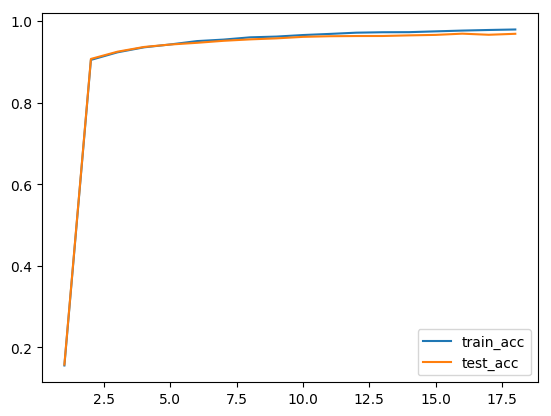

PyObject <matplotlib.legend.Legend object at 0x7f903b50d710>

In [57]:
x1 = [1:length(train_acc_list);]
plt.plot(x1, train_acc_list, label="train_acc")
plt.plot(x1, test_acc_list, label="test_acc")
plt.legend()